In [18]:
import tensorflow as tf
import yfinance as yf
from tensorflow import keras
import numpy as np
import vectorbt as vbt
import pandas as pd

In [19]:
allData = pd.read_csv("PEN_USD1.csv",index_col="Date")
allData.dropna(subset=["Close"],inplace=True)
allData = allData[-2250:]
buffer = allData["Close"]
testDataFrame = buffer[-450:]
trainDataFrame = buffer[0:-450]

<AxesSubplot:xlabel='Date'>

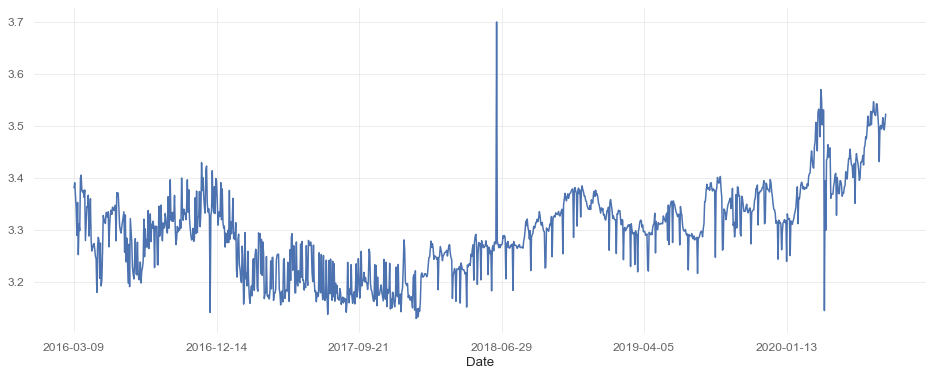

In [20]:
trainDataFrame.plot(figsize=(16,6))

<AxesSubplot:xlabel='Date'>

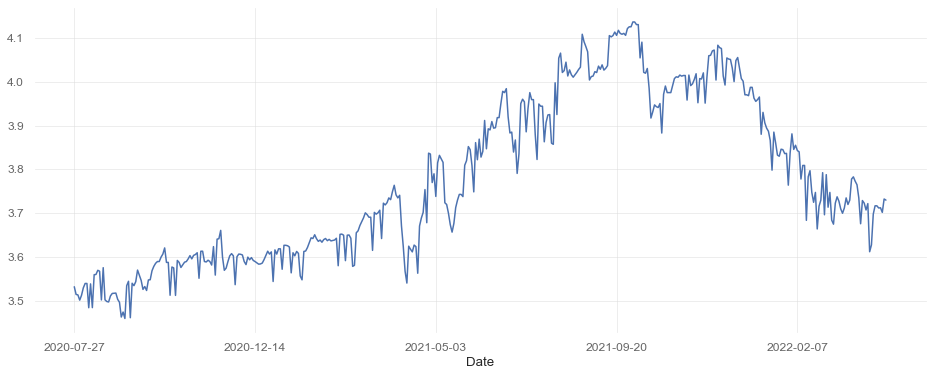

In [21]:
testDataFrame.plot(figsize=(16,6))

In [22]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
trainingSet = pd.DataFrame(trainDataFrame)
training_set_scaled = sc.fit_transform(trainingSet)
training_set_scaled

array([[0.44097527],
       [0.45763901],
       [0.41676899],
       ...,
       [0.63602877],
       [0.65970882],
       [0.68952815]])

In [23]:
X_train = []
Y_train = []
for i in range(60,trainingSet.size):
    X_train.append(training_set_scaled[i-60:i,0])
    Y_train.append(training_set_scaled[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [25]:
regressor = Sequential()

In [26]:
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))


In [27]:
regressor.compile(optimizer='adam', loss='mean_squared_error')

regressor.fit(X_train, Y_train, epochs=100, batch_size=32)
regressor.save("Sol_BOT.bot")

Epoch 1/100
1080/1080 [==============================] - 6s 6ms/sample - loss: 0.0212
Epoch 2/100
1080/1080 [==============================] - 4s 4ms/sample - loss: 0.0082
Epoch 3/100
1080/1080 [==============================] - 4s 4ms/sample - loss: 0.0075
Epoch 4/100
1080/1080 [==============================] - 4s 4ms/sample - loss: 0.0080
Epoch 5/100
1080/1080 [==============================] - 4s 4ms/sample - loss: 0.0066
Epoch 6/100
1080/1080 [==============================] - 4s 4ms/sample - loss: 0.0069
Epoch 7/100
1080/1080 [==============================] - 4s 4ms/sample - loss: 0.0068
Epoch 8/100
1080/1080 [==============================] - 4s 4ms/sample - loss: 0.0069
Epoch 9/100
1080/1080 [==============================] - 4s 4ms/sample - loss: 0.0066
Epoch 10/100
1080/1080 [==============================] - 4s 4ms/sample - loss: 0.0064
Epoch 11/100
1080/1080 [==============================] - 4s 4ms/sample - loss: 0.0067
Epoch 12/100
1080/1080 [============================

In [28]:
testSet = pd.DataFrame(trainDataFrame)

In [29]:
inputs = buffer[len(trainDataFrame)-60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(60,testDataFrame.size):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
predicted_close_value = regressor.predict(X_test)
predicted_close_value = sc.inverse_transform(predicted_close_value)

C:\Users\90507\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


In [30]:
predicted_close_value = pd.DataFrame(predicted_close_value)
predicted_close_value.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       390 non-null    float32
dtypes: float32(1)
memory usage: 1.6 KB


In [31]:
test_data = allData[-450:-60]
real_close_value = test_data.iloc[:,1:2].values

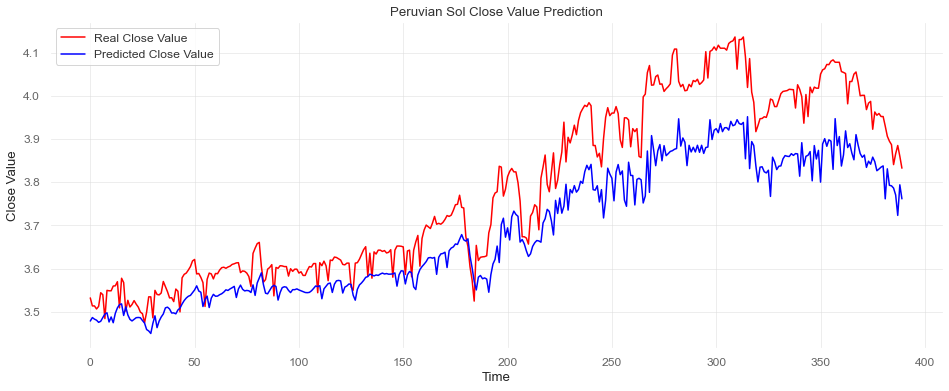

In [32]:
import matplotlib.pyplot as plt
figure = plt.figure()
figure.set_figwidth(16)
figure.set_figheight(6)
plt.plot(real_close_value, color='red', label='Real Close Value')
plt.plot(predicted_close_value, color='blue', label='Predicted Close Value')
plt.title('Peruvian Sol Close Value Prediction')
plt.xlabel('Time')
plt.ylabel('Close Value')
plt.legend()
plt.show()

In [33]:
from scipy.stats import pearsonr
from pingouin import corr
from researchpy.correlation import corr_case

In [34]:
result = pd.DataFrame(real_close_value)
result.insert(1,"Predicted", pd.DataFrame(predicted_close_value))
result.columns=["Real","Predicted"]
print("Correlation Between Real and Predicted Values = %",100*result["Real"].corr(result["Predicted"],method="pearson"))
accuracy = 100 * np.mean(np.abs(real_close_value-predicted_close_value) / real_close_value)
print("Percentage of Accuracy Between Real and Predicted Values = %01.3f" %(100 - accuracy,))


Correlation Between Real and Predicted Values = % 97.80668166740007
Percentage of Accuracy Between Real and Predicted Values = 97.497
